This file is copied from

https://gluon-cv.mxnet.io/build/examples_action_recognition/dive_deep_tsn_ucf101.html 

and modified to be used on the HMDB51 dataset.

In [1]:
%matplotlib inline

2. Dive Deep into Training TSN mdoels on HMDB51
==================================================

This is a video action recognition tutorial using Gluon CV toolkit, a step-by-step example.
The readers should have basic knowledge of deep learning and should be familiar with Gluon API.
New users may first go through `A 60-minute Gluon Crash Course <http://gluon-crash-course.mxnet.io/>`_.
You can `Start Training Now`_ or `Dive into Deep`_.

Start Training Now
~~~~~~~~~~~~~~~~~~


Network Structure
-----------------

First, let's import the necessary libraries into python.


In [2]:
from __future__ import division

import argparse, time, logging, os, sys, math

import numpy as np
import mxnet as mx
import gluoncv as gcv
from mxnet import gluon, nd, init, context
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

from gluoncv.data.transforms import video
from gluoncv.data import HMDB51
from gluoncv.model_zoo import get_model
from gluoncv.utils import makedirs, LRSequential, LRScheduler, split_and_load, TrainingHistory

Video action recognition is a classification problem.
Here we pick a simple yet well-performing structure, ``resnet50_v1b_hmdb51``, for the
tutorial. In addition, we use the the idea of temporal segments (TSN) [Wang16]_
to wrap the backbone VGG16 network for adaptation to video domain.

`TSN <https://arxiv.org/abs/1608.00859>`_ is a widely adopted video
classification method. It is proposed to incorporate temporal information from an entire video.
The idea is straightforward: we can evenly divide the video into several segments,
process each segment individually, obtain segmental consensus from each segment, and perform
final prediction. TSN is more like a general algorithm, rather than a specific network architecture.
It can work with both 2D and 3D neural networks.



In [3]:
# number of GPUs to use
num_gpus = 1
ctx = [mx.gpu(i) for i in range(num_gpus)]

# Get the model vgg16_hmdb51 with temporal segment network, with 101 output classes, without pre-trained weights
net = get_model(name='resnet50_v1b_hmdb51', nclass=51, num_segments=3)
net.collect_params().reset_ctx(ctx)
print(net)

ActionRecResNetV1b(
  (conv1): Conv2D(3 -> 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
  (relu): Activation(relu)
  (maxpool): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(1, 1), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (layer1): HybridSequential(
    (0): BottleneckV1b(
      (conv1): Conv2D(64 -> 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
      (relu1): Activation(relu)
      (conv2): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
      (relu2): Activation(relu)
      (conv3): Conv2D(64 -> 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm(ax

Data Augmentation and Data Loader
---------------------------------

Data augmentation for video is different from image. For example, if you
want to randomly crop a video sequence, you need to make sure all the video
frames in this sequence undergo the same cropping process. We provide a
new set of transformation functions, working with multiple images.
Please checkout the `video.py <../../../gluoncv/data/transforms/video.py>`_ for more details.
Most video data augmentation strategies used here are introduced in [Wang15]_.



In [4]:
transform_train = transforms.Compose([
    # Fix the input video frames size as 256×340 and randomly sample the cropping width and height from
    # {256,224,192,168}. After that, resize the cropped regions to 224 × 224.
    video.VideoMultiScaleCrop(size=(224, 224), scale_ratios=[1.0, 0.875, 0.75, 0.66]),
    # Randomly flip the video frames horizontally
    video.VideoRandomHorizontalFlip(),
    # Transpose the video frames from height*width*num_channels to num_channels*height*width
    # and map values from [0, 255] to [0,1]
    video.VideoToTensor(),
    # Normalize the video frames with mean and standard deviation calculated across all images
    video.VideoNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

With the transform functions, we can define data loaders for our
training datasets.



In [5]:
# Batch Size for Each GPU
per_device_batch_size = 15
# Number of data loader workers
num_workers = 4
# Calculate effective total batch size
batch_size = per_device_batch_size * num_gpus

# Set train=True for training the model. Here we set num_segments to 3 to enable TSN training.
train_dataset = HMDB51(train=True, num_segments=3, transform=transform_train)
print('Load %d training samples.' % len(train_dataset))
train_data = gluon.data.DataLoader(train_dataset, batch_size=batch_size,
                                   shuffle=True, num_workers=num_workers)

Load 3570 training samples.


Optimizer, Loss and Metric
--------------------------



In [6]:
# Learning rate decay factor
lr_decay = 0.1
# Epochs where learning rate decays
lr_decay_epoch = [30, 50, np.inf]

# Stochastic gradient descent
optimizer = 'sgd'
# Set parameters
optimizer_params = {'learning_rate': 0.01, 'wd': 0.0001, 'momentum': 0.9}

# Define our trainer for net
trainer = gluon.Trainer(net.collect_params(), optimizer, optimizer_params)

In order to optimize our model, we need a loss function.
For classification tasks, we usually use softmax cross entropy as the
loss function.



In [7]:
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

For simplicity, we use accuracy as the metric to monitor our training
process. Besides, we record metric values, and will print them at the
end of training.



In [8]:
train_metric = mx.metric.Accuracy()
train_history = TrainingHistory(['training-acc'])

Training
--------

After all the preparations, we can finally start training!
Following is the script.

<div class="alert alert-info"><h4>Note</h4><p>In order to finish the tutorial quickly, we only train for 3 epochs, and 100 iterations per epoch.
  In your experiments, we recommend setting ``epochs=80`` for the full HMDB51 dataset.</p></div>



.........................................................................................................................................................................................................|
[Epoch 0] train=0.081924 loss=3.767400 time: 90.525495
.........................................................................................................................................................................................................|
[Epoch 1] train=0.103483 loss=3.586216 time: 90.619416
.........................................................................................................................................................................................................|
[Epoch 2] train=0.157546 loss=3.261760 time: 92.949263
.........................................................................................................................................................................................................|
[Epoch 3] train=0.20597

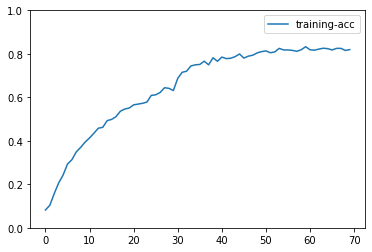

In [9]:
epochs = 70
lr_decay_count = 0

for epoch in range(epochs):
    tic = time.time()
    train_metric.reset()
    train_loss = 0

    # Learning rate decay
    if epoch == lr_decay_epoch[lr_decay_count]:
        new_lr = trainer.learning_rate*lr_decay
        trainer.set_learning_rate(new_lr)
        print("New learning rate: ", new_lr)
        lr_decay_count += 1
        
    # Loop through each batch of training data
    for i, batch in enumerate(train_data):
        print(".", end="")
        # Extract data and label
        data = split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = split_and_load(batch[1], ctx_list=ctx, batch_axis=0)

        # AutoGrad
        with ag.record():
            output = []
            for _, X in enumerate(data):
                X = X.reshape((-1,) + X.shape[2:])
                pred = net(X)
                output.append(pred)
            loss = [loss_fn(yhat, y) for yhat, y in zip(output, label)]

        # Backpropagation
        for l in loss:
            l.backward()

        # Optimize
        trainer.step(batch_size)

        # Update metrics
        train_loss += sum([l.mean().asscalar() for l in loss])
        train_metric.update(label, output)

        if i == 200:
            print("|")
            break

    name, acc = train_metric.get()

    # Update history and print metrics
    train_history.update([acc])
    print('[Epoch %d] train=%f loss=%f time: %f' %
        (epoch, acc, train_loss / (i+1), time.time()-tic))

# We can plot the metric scores with:
train_history.plot()

You can `Start Training Now`_.

If you would like to use a bigger 3D model (e.g., I3D) on a larger dataset (e.g., Kinetics400),
feel free to read the next `tutorial on Kinetics400 <demo_i3d_kinetics400.html>`__.

References
----------

.. [Wang15] Limin Wang, Yuanjun Xiong, Zhe Wang, and Yu Qiao. \
    "Towards Good Practices for Very Deep Two-Stream ConvNets." \
    arXiv preprint arXiv:1507.02159 (2015).

.. [Wang16] Limin Wang, Yuanjun Xiong, Zhe Wang, Yu Qiao, Dahua Lin, Xiaoou Tang and Luc Van Gool. \
    "Temporal Segment Networks: Towards Good Practices for Deep Action Recognition." \
    In European Conference on Computer Vision (ECCV). 2016.

